In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

## Distance matrix

In [3]:
df = pd.read_csv("results/train_clean.csv", index_col=0)

In [4]:
df['countryOfOrigin'] = df['countryOfOrigin'].apply(ast.literal_eval)
df['genres'] = df['genres'].apply(ast.literal_eval)

In [5]:
mbl = MultiLabelBinarizer()
countries_df = pd.DataFrame(mbl.fit_transform(df['countryOfOrigin']), columns=mbl.classes_, index=df.index)
countries_df = countries_df.astype('bool')
most_fr_countries = countries_df.sum().sort_values(ascending=False)

In [6]:
countries_df = countries_df[most_fr_countries.head(4).index]
countries_df.head()

,US,GB,JP,FR
0,True,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


In [7]:
genres_df = pd.DataFrame(mbl.fit_transform(df['genres']), columns=mbl.classes_, index=df.index)
genres_df = genres_df.astype('bool')

In [8]:
numeric_cols = df.dtypes[(df.dtypes == 'float64') | (df.dtypes == 'int64')].index
numeric_df = df[numeric_cols]
numeric_df.drop(['ratingNum'], axis=1, inplace=True)
numeric_df.head()

/tmp/ipykernel_35817/1867124789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df.drop(['ratingNum'], axis=1, inplace=True)


,startYear,runtimeMinutes,numVotes,totalImages,totalCredits,numRegions,numGenres,criticReviewsRatio
0,1995,3.713572,6.659294,0.693147,3.091042,0.693147,3,1.000000
1,1982,3.273393,2.484907,0.693147,0.693147,0.693147,1,0.000000
2,1992,4.510860,3.663562,0.693147,3.218876,0.693147,1,0.000000
3,2021,3.465736,2.772589,3.135494,4.043051,0.693147,1,0.000000
4,2020,4.394449,9.662625,5.852202,3.871201,3.496508,3,0.008772


In [9]:
title_df = pd.get_dummies(df['titleType'], columns=['titleType'], drop_first=True)
title_df.head()

,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame
0,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False


In [10]:
bool_cols = df.dtypes[df.dtypes == 'bool'].index
bool_df = df[bool_cols]
bool_df.head()

,canHaveEpisodes,awardsAndNominations,hasVideos,moreCountriesOfOrigin
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,True,False,False,False
4,True,True,True,False


In [11]:
scaler = StandardScaler()
numeric_df = scaler.fit_transform(numeric_df)

In [12]:
distance_matrix = pdist(numeric_df, metric='euclidean')
del numeric_df
distance_matrix += pdist(bool_df, metric='jaccard')
del bool_df
distance_matrix += pdist(countries_df, metric='jaccard')
del countries_df
distance_matrix += pdist(genres_df, metric='jaccard')
del genres_df
distance_matrix += pdist(title_df, metric='jaccard')
del title_df

distance_matrix = squareform(distance_matrix)

In [13]:
distance_matrix.shape

(16431, 16431)

## kth neighbour distance

In [14]:
ks = [8, 16, 32, 64, 128, 200, 300, 500]
kth_distances = {k: []
                 for k in ks}

for d in distance_matrix:
    sorted_indexes = np.argsort(d)
    for k in ks:
        kth_distances[k].append(d[sorted_indexes[k]])

len(kth_distances[16])

16431

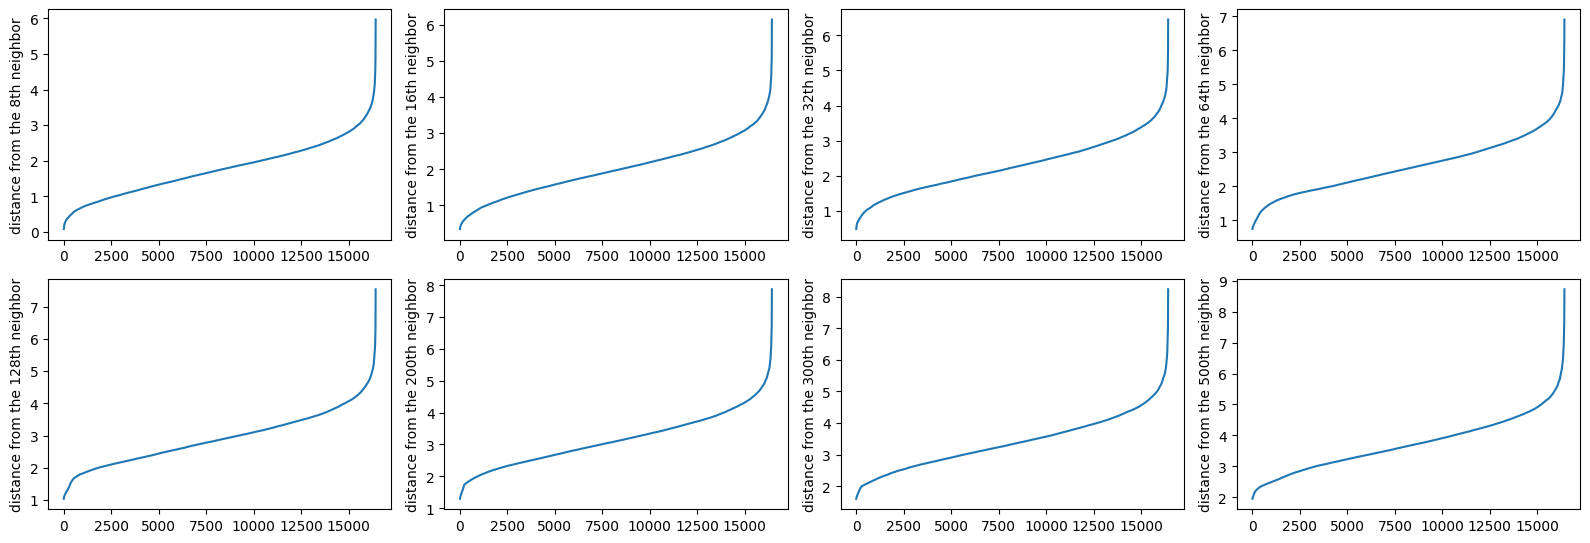

In [15]:
fig = plt.figure(figsize=(16, 8))
fig_dims = ((len(kth_distances) // 4) + 1, 4)

for i, k in enumerate(ks):
    distances = kth_distances[k]

    plt.subplot2grid(fig_dims, (i//4, i%4))
    plt.plot(range(len(distances)), sorted(distances))
    plt.ylabel(f'distance from the {k}th neighbor')

plt.tight_layout()
plt.show()

## Clustering
### DBSCAN

In [44]:
dbscan = DBSCAN(eps=2, min_samples=32, metric='precomputed')
dbscan.fit(distance_matrix)

DBSCAN(eps=2, metric='precomputed', min_samples=32)

In [45]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([5870, 9773,  615,   32,  107,   34]))

In [46]:
labels = dbscan.labels_
inliers = labels != -1

In [47]:
distance_inliers = distance_matrix[np.ix_(inliers, inliers)]
distance_inliers.shape

(10561, 10561)

In [48]:
silhouette_score(distance_inliers, labels[inliers], metric='precomputed')

0.039494256581420285

### OPTICS

In [28]:
%%time

optics = OPTICS(min_samples=32, metric='precomputed', n_jobs=-1)
optics.fit(distance_matrix)

CPU times: user 34min 38s, sys: 35.1 s, total: 35min 13s
Wall time: 37min 35s


OPTICS(metric='precomputed', min_samples=32, n_jobs=-1)

In [29]:
np.unique(optics.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6]),
 array([16042,    74,    43,    50,    81,    56,    36,    49]))

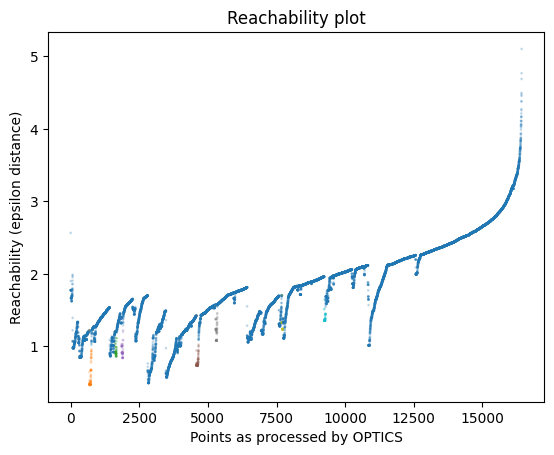

In [51]:
space = np.arange(len(df))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]
plt.title("Reachability plot")
plt.ylabel("Reachability (epsilon distance)")
plt.xlabel("Points as processed by OPTICS")

plt.scatter(space, reachability, alpha=.2, s=1, c=labels, cmap='tab10')

The reachability plot doesn't really show any valleys, which explains why both dbscan and optics fail to detect significative clusters in the data.